<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-MBD-EN/blob/main/ir_practice/information_retrieval_vsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

In [1]:
# @title Colab Setup

repository_name = "NLP-MBD-EN"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

print("### Cloning the Repository ###")
! git clone $repository_url
print()

print("### Installing requirements ###")
! pip3 install -Uqqr $repository_name/ir_practice/requirements.txt

### Cloning the Repository ###
fatal: destination path 'NLP-MBD-EN' already exists and is not an empty directory.

### Installing requirements ###


Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

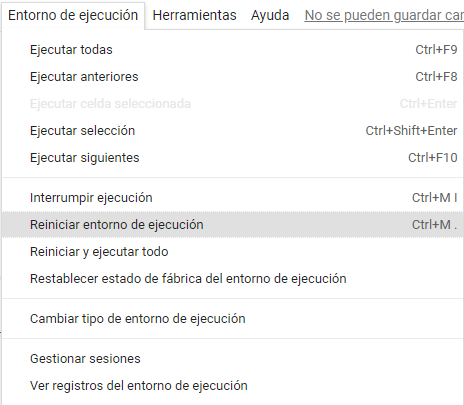

Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

# TF-IDF based VSM Retrieval Practice

In this practice, we will build a simplistic Information Retrieval (IR) system utilizing the TF-IDF (Term Frequency-Inverse Document Frequency) technique. This technique is fundamental in the realm of text analysis and information retrieval for understanding how important a word is in a document within a collection of documents (corpus).

Initially, we'll set up our environment, import necessary libraries, and create a sample dataset of documents. Following this, we'll define a function to preprocess these documents - this includes removing punctuation, converting text to lowercase, and stripping stopwords.

Upon preprocessing, we'll construct a TF-IDF matrix which will serve as the foundation for our retrieval system. We'll define a function to find the most relevant documents for a given query, based on cosine similarity between the TF-IDF vectors of the documents and the query.

We'll test the system with a sample query to see how well our TF-IDF based retrieval system is performing.

Following this, we'll explore improving retrieval using the BM25 algorithm, which is a state-of-the-art ranking function used in information retrieval. This will involve updating our `find_relevant_docs` function to utilize the BM25 algorithm for scoring and ranking documents in relation to a query.

In the latter part of the practice, we'll transition into leveraging Neural Network models for our IR system. We will utilize a pre-trained language model to generate embeddings for our documents and queries, and modify our `find_relevant_docs` function to compute similarity in the embedding space. This approach, utilizing neural models, is a step towards more advanced and effective IR systems.

We'll test this neural network-based model with a sample query and compare the results with the previous approaches.

This notebook is structured in a way to provide a step-by-step transition from a simple TF-IDF based system to a more complex neural network-based retrieval system, showcasing the evolution of IR systems with the advent of deep learning.


Let's start with the required imports

In [2]:
import os
import nltk
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize


In [7]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

To explore different techniques for retrieving relevant text documents based on a given query. We'll be working with a small sample dataset of text documents, covering a variety of topics. The documents are as follows:


In [4]:
documents = [
    "The sky is blue and beautiful.",
    "Love this blue and beautiful sky!",
    "The quick brown fox jumps over the lazy dog.",
    "A king's breakfast has sausages, ham, bacon, eggs, toast, and beans.",
    "I love green eggs, ham, sausages, and bacon!",
    "The brown fox is quick and the blue dog is lazy!",
    "The sky is very blue and the sky is very beautiful today.",
    "The dog is lazy but the brown fox is quick!"
]


In the `preprocess` function defined below, we perform three crucial text preprocessing steps which are common in many Natural Language Processing (NLP) tasks:

1. **Punctuation Removal and Case Conversion**:
    - Strips off punctuation characters (like .,!,? etc.) from the text.
    - Converts all characters to lowercase to maintain uniformity and avoid duplication based on case differences.

2. **Tokenization**:
    - Splits the text into individual words or tokens using the `word_tokenize` function from the `nltk` library.

3. **Stopword Removal**:
    - Filters out common words (e.g., "is", "the", "and") that usually have less significance in understanding the text's essence.
    - Utilizes the `stopwords` module from `nltk` to identify and remove these words.

After preprocessing, the function returns the cleaned text, which is now ready for further processing or analysis.


In [5]:
def preprocess(text):
    # Remove punctuation and convert to lowercase
    text = ''.join([c.lower() for c in text if c not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [t for t in tokens if t not in stop_words]

    return ' '.join(filtered_tokens)


Let's now apply this fucntion to preprocess the sample dataset we created above and vectorize it to create the Document-Term matrix using TF-IDF as weighting function.

As I hope you remember, this matrix represents the importance of each term in each document in a numerical format.

In [8]:
preprocessed_docs = [preprocess(doc) for doc in documents]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_docs)


Now we need to define a function to find the most relevant documents for a given query.

In the `find_relevant_docs` function, we preprocess the input query, convert it to a TF-IDF vector, compute the cosine similarity between the query vector and the document vectors, and then retrieve the indices of the most similar documents along with their respective similarity scores.

In [9]:
def find_relevant_docs(query, tfidf_matrix, vectorizer, top_n=3):
    # Preprocess the query and convert it to a TF-IDF vector
    preprocessed_query = preprocess(query)
    query_vector = vectorizer.transform([preprocessed_query])

    # Compute the cosine similarity between the query vector and document vectors
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix)

    # Get the indices of the most similar documents
    most_similar_doc_indices = np.argsort(cosine_similarities).flatten()[::-1][:top_n]
    top_doc_scores = sorted(cosine_similarities[0, most_similar_doc_indices], reverse=True)

    return most_similar_doc_indices, top_doc_scores


Finally, time to test it all together with a sample query

In [10]:
query = "What is the color of the sky and the ocean?"

relevant_doc_indices, top_doc_scores = find_relevant_docs(query, tfidf_matrix, vectorizer)

# Print the results
for idx, (doc_id, score) in enumerate(zip(relevant_doc_indices, top_doc_scores), start=1):
    print(f"Rank {idx}, Document ID: {doc_id}, Score: {score:.2f}, Text: {documents[doc_id]}")

Rank 1, Document ID: 6, Score: 0.72, Text: The sky is very blue and the sky is very beautiful today.
Rank 2, Document ID: 0, Score: 0.60, Text: The sky is blue and beautiful.
Rank 3, Document ID: 1, Score: 0.49, Text: Love this blue and beautiful sky!


# Improving Retrieval: BM25

In this section, we will explore an improvement over the TF-IDF model by using the BM25 (Best Matching 25) ranking function for information retrieval. BM25 is known for its effectiveness in ranking documents relevant to a particular query. Unlike TF-IDF which considers term frequency and inverse document frequency, BM25 goes a step further to incorporate a relevance score between a query and a document. This is particularly useful in cases where documents are of varying lengths. Let's implement BM25 and compare its performance with the TF-IDF model.


As usual, we start with the required imports

In [11]:
from rank_bm25 import BM25Okapi
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Initialize the BM25 object:

In [12]:
bm25 = BM25Okapi(preprocessed_docs)



In this updated `find_relevant_docs` function, we now accommodate the BM25 model for retrieving documents. Here's a breakdown of the process:

1. The query is preprocessed using the `preprocess` function.
2. BM25 scores for the query against all documents in the corpus are computed using the `get_scores` method of the `BM25Okapi` object.
3. We then sort these scores to find the indices of the documents with the highest relevance scores.
4. The function returns the indices of the top `n` documents along with their respective scores.



In [13]:
def find_relevant_docs(query, bm25, top_n=3):
    # Preprocess the query
    tokenized_query = preprocess(query)

    # Get the BM25 scores for the query
    relevance_scores = bm25.get_scores(tokenized_query)

    # Sort the results by relevance scores
    sorted_indices = sorted(range(len(relevance_scores)), key=lambda i: relevance_scores[i], reverse=True)[:top_n]
    top_doc_scores = [relevance_scores[i] for i in sorted_indices]

    return sorted_indices, top_doc_scores


And test it again with the new additions

In [14]:
query = "What is the color of the sky and the ocean?"

relevant_doc_indices, top_doc_scores = find_relevant_docs(query, bm25)

# Print the results
for idx, (doc_id, score) in enumerate(zip(relevant_doc_indices, top_doc_scores), start=1):
    print(f"Rank {idx}, Document ID: {doc_id}, Score: {score:.2f}, Text: {documents[doc_id]}")


Rank 1, Document ID: 0, Score: -1.76, Text: The sky is blue and beautiful.
Rank 2, Document ID: 1, Score: -2.29, Text: Love this blue and beautiful sky!
Rank 3, Document ID: 6, Score: -2.42, Text: The sky is very blue and the sky is very beautiful today.


This example demonstrates a simple IR system using the BM25 ranking function. It preprocesses the documents and the query, tokenizing them and removing punctuation, converting to lowercase, and removing stopwords. Then, it computes the BM25 relevance scores and finds the most relevant documents. This approach can be easily adapted to a larger dataset or web pages by preprocessing and storing them in a similar fashion

# Improve the model: Neural Nets

To build an Information Retrieval (IR) system using neural models, you can leverage pre-trained language models such as BERT, DistilBERT, or any other model from the Hugging Face Transformers library. In this example, we'll use the Sentence Transformers library, which is specifically designed for creating sentence embedding (i.e., representations).

The specific model we are going to use is a Distilled version of RoBERTa fine-tuned to generate sentence representations: https://huggingface.co/sentence-transformers/paraphrase-distilroberta-base-v1

In [15]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("paraphrase-distilroberta-base-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now we can use this model for creating the embeddings of the sample documents. The model will generate an embedding of 768 dimensions for each one of the 8 documents we have

In [16]:
document_embeddings = model.encode(documents)

document_embeddings.shape

(8, 768)

We need to adapt the `find_relevant_docs` to use the document embeddings. In particular, it will find the documents which embedding is closer to the embedding representation of the query (i.e., generated also by the neural model)

In [17]:
def find_relevant_docs(query, corpus_embeddings, model, top_k=3):

    query_embedding = model.encode(query, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    cos_scores = cos_scores.cpu()

    # Sort the results by relevance scores
    top_results = torch.topk(cos_scores, k=top_k)

    # Retrieve the IDs and relevance scores of the top documents
    top_doc_ids = top_results.indices.tolist()
    top_doc_scores = top_results.values.tolist()

    return top_doc_ids, top_doc_scores


Finally, let's test the model with a sample query

In [18]:
query = "What is the color of the sky and the ocean?"

relevant_doc_indices, top_doc_scores = find_relevant_docs(query, document_embeddings, model)

# Print the results
for idx, (doc_id, score) in enumerate(zip(relevant_doc_indices, top_doc_scores), start=1):
    print(f"Rank {idx}, Document ID: {doc_id}, Score: {score:.2f}, Text: {documents[doc_id]}")


Rank 1, Document ID: 0, Score: 0.51, Text: The sky is blue and beautiful.
Rank 2, Document ID: 1, Score: 0.50, Text: Love this blue and beautiful sky!
Rank 3, Document ID: 6, Score: 0.42, Text: The sky is very blue and the sky is very beautiful today.


This example demonstrates a simple IR system using neural models, specifically the Sentence Transformers library, which is built on top of Hugging Face Transformers. It creates sentence embeddings for both the query and the documents and then computes the cosine similarity to find the most relevant documents. You can experiment with other pre-trained models from the Sentence Transformers library or even fine-tune your model on your domain-specific dataset for better results.